In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

2025-10-26 08:33:55.088453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2025-10-26 08:25:52--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 2600:9000:20ab:e600:17:b174:6d00:93a1, 2600:9000:20ab:9400:17:b174:6d00:93a1, 2600:9000:20ab:9600:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:e600:17:b174:6d00:93a1|:443... failed: Connection refused.
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:9400:17:b174:6d00:93a1|:443... failed: Connection refused.
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:9600:17:b174:6d00:93a1|:443... failed: Connection refused.
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:8000:17:b174:6d00:93a1|:443... failed: Connection refused.
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:ea00:17:b174:6d00:93a1|:443... failed: Connection refused.
Connecting to huggingface.co (huggingface.co)|2600:9000:20ab:1000:17:b174:6d00:93a1|:443... failed: Connection refused.
Con

In [2]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    # in order to avoid `NONE` during shape inference
    low_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    enhanced_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset.element_spec)
print("Val Dataset:", val_dataset.element_spec)

Train Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))
Val Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))


I0000 00:00:1761464043.916492   70521 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8941 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [3]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [4]:
class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

In [5]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

In [6]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

Epoch 1/50


2025-10-26 08:35:17.010805: I external/local_xla/xla/service/service.cc:163] XLA service 0x775ce0005080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 08:35:17.010819: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-26 08:35:19.686180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-26 08:35:25.736677: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-10-26 08:35:25.736750: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-10-26 08:35:33.892431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-26 08:35:36.898223: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 0.2138 - peak_signal_noise_ratio: 61.7743

2025-10-26 08:37:00.973247: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-10-26 08:37:00.973322: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-10-26 08:37:01.364604: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[4,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,128,128]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 08:37:01.777690: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel 

75/75 ━━━━━━━━━━━━━━━━━━━━ 182s 762ms/step - loss: 0.1992 - peak_signal_noise_ratio: 62.1528 - val_loss: 0.1527 - val_peak_signal_noise_ratio: 64.5397 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 752ms/step - loss: 0.1809 - peak_signal_noise_ratio: 63.0258 - val_loss: 0.1250 - val_peak_signal_noise_ratio: 65.8991 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 765ms/step - loss: 0.1706 - peak_signal_noise_ratio: 63.4458 - val_loss: 0.1214 - val_peak_signal_noise_ratio: 65.9996 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 771ms/step - loss: 0.1673 - peak_signal_noise_ratio: 63.4825 - val_loss: 0.1232 - val_peak_signal_noise_ratio: 65.7450 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 774ms/step - loss: 0.1638 - peak_signal_noise_ratio: 63.7197 - val_loss: 0.1234 - val_peak_signal_noise_ratio: 65.9507 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 780ms/step - loss: 0.16

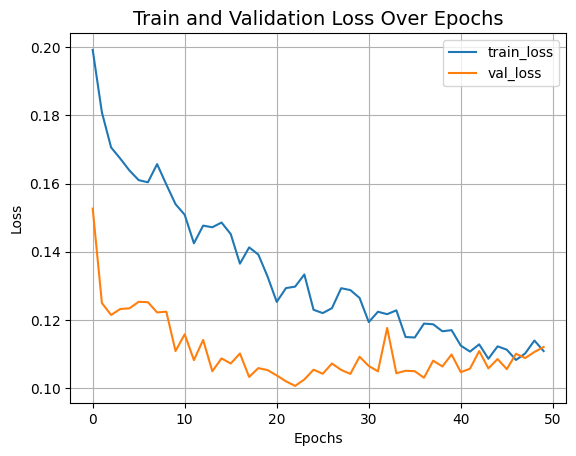

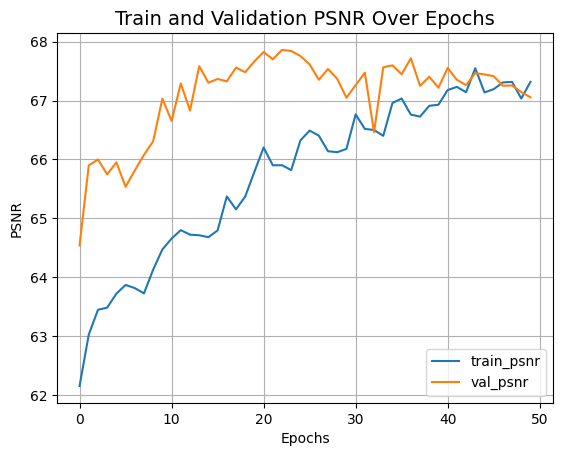

In [7]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
    metrics=[peak_signal_noise_ratio],
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)


def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"Train and Validation {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss", "Loss")
plot_history("peak_signal_noise_ratio", "PSNR")

In [10]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image, verbose=0)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

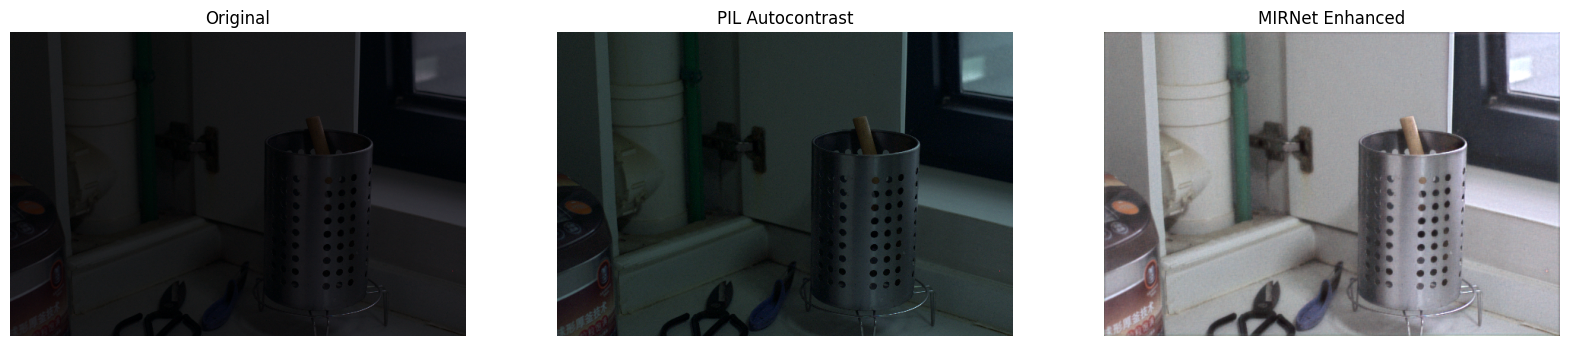

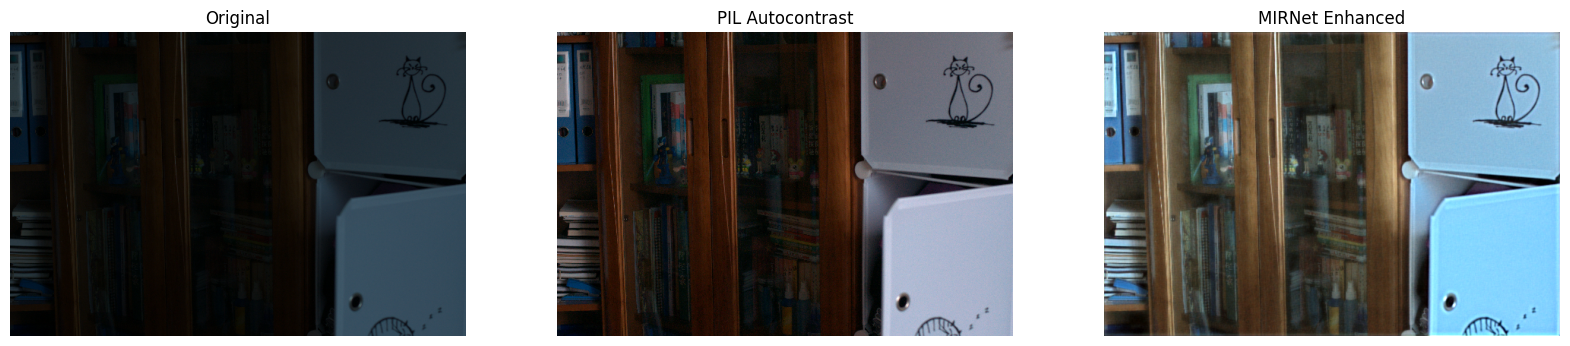

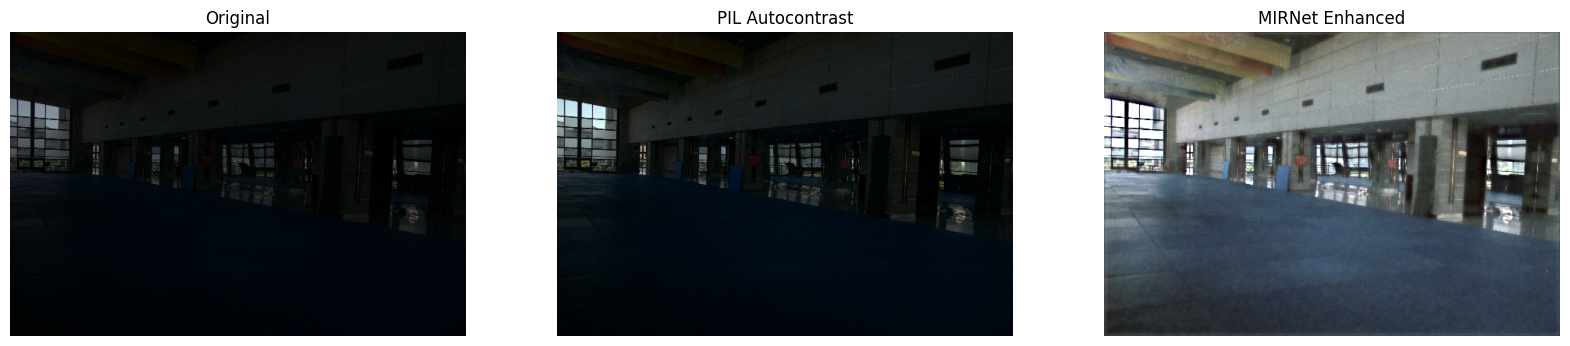

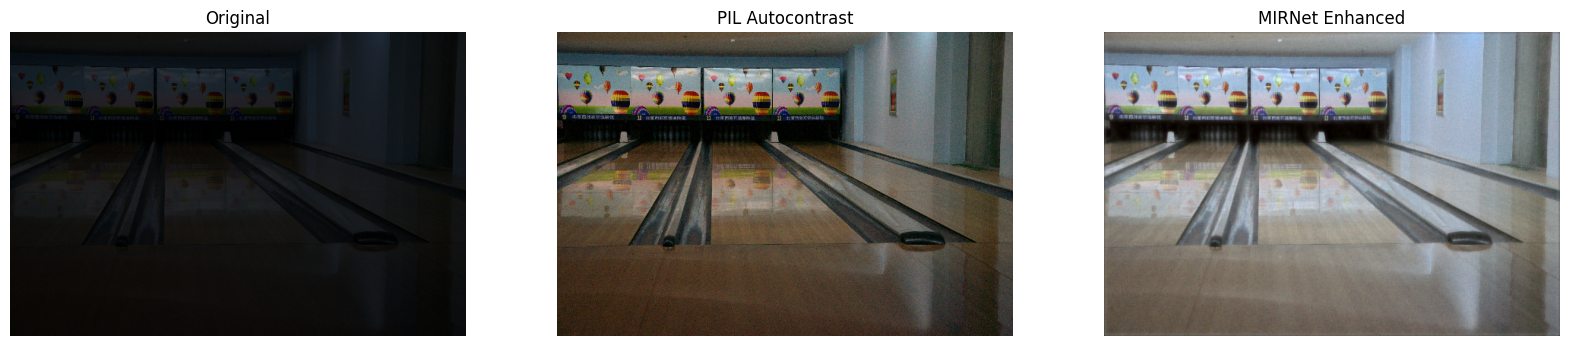

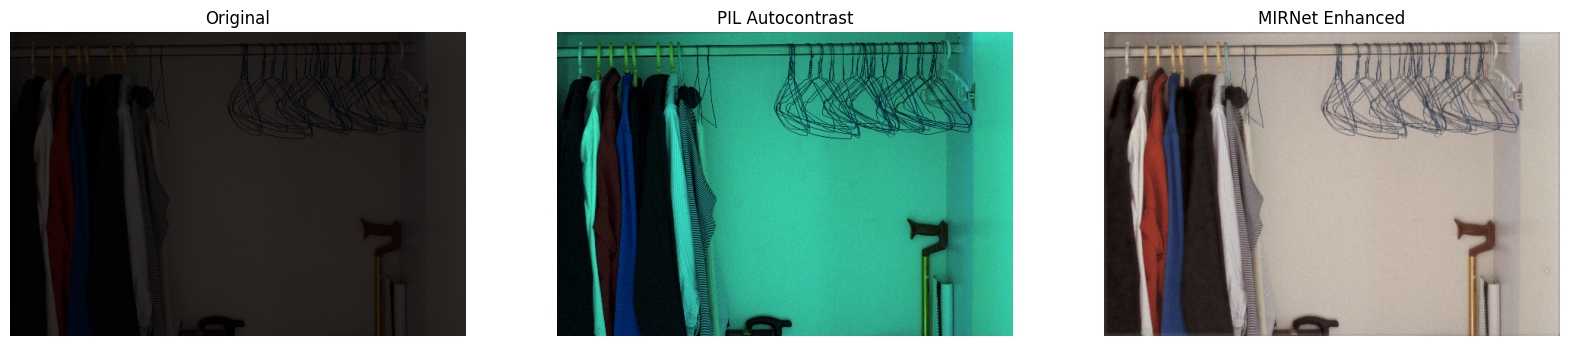

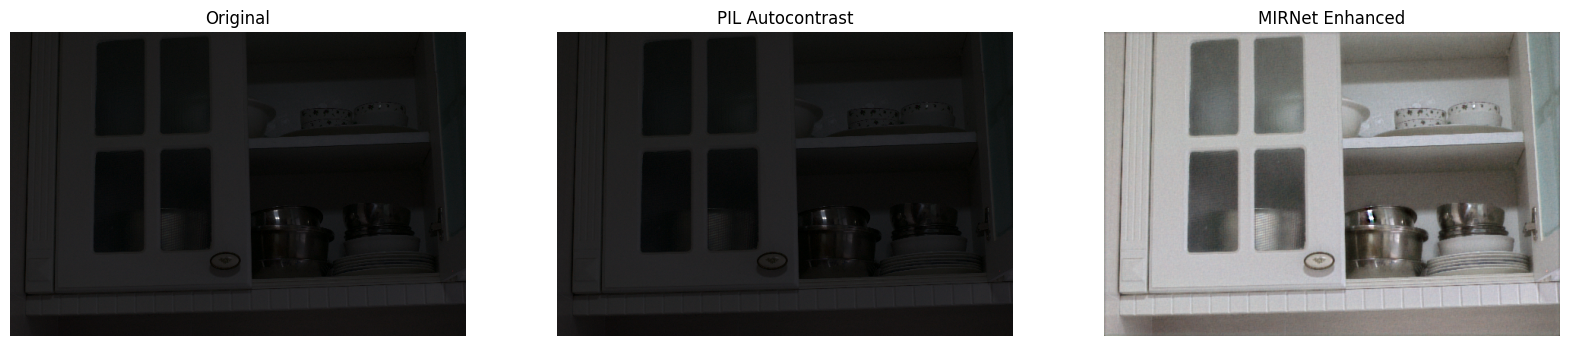

In [11]:
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (20, 12),
    )